In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Avanee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Avanee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Extract dataset from zip

import zipfile

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("models/fake_news_dataset")

In [9]:
# Load and label data
fake_df = pd.read_csv("models/fake_news_dataset/News_Dataset/Fake.csv")
real_df = pd.read_csv("models/fake_news_dataset/News_Dataset/True.csv")
fake_df["label"] = 0
real_df["label"] = 1

In [11]:
# Balance data
min_len = min(len(fake_df), len(real_df))
fake_df = fake_df.sample(min_len, random_state=42)
real_df = real_df.sample(min_len, random_state=42)
df = pd.concat([fake_df, real_df]).sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
# Combine title and text, handle missing
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['combined'] = df['title'] + ' ' + df['text']

In [15]:
# Text cleaning
def clean_text(text):
    text = re.sub(r'http\S+|[^a-zA-Z\s]', '', text.lower())
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens if word not in stop_words])

df['cleaned'] = df['combined'].apply(clean_text)

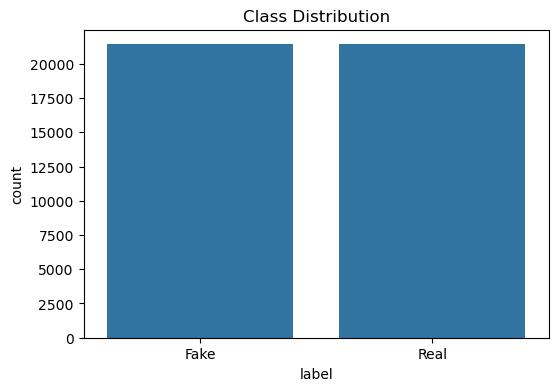

In [17]:
# EDA: Class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Class Distribution")
plt.show()

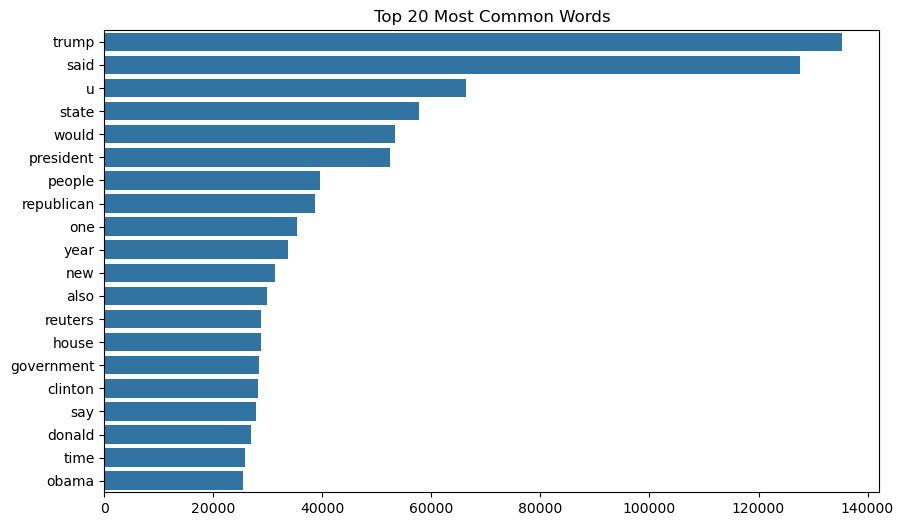

In [19]:
# EDA: Most frequent words (top 20)
from collections import Counter
all_words = ' '.join(df['cleaned']).split()
most_common = Counter(all_words).most_common(20)
words, counts = zip(*most_common)
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 Most Common Words")
plt.show()

In [21]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_df=0.8, min_df=10, max_features=8000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned'])
y = df['label']

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Train model
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [27]:
# Evaluation
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9458386833197152
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4362
           1       0.94      0.95      0.94      4205

    accuracy                           0.95      8567
   macro avg       0.95      0.95      0.95      8567
weighted avg       0.95      0.95      0.95      8567



In [29]:
# Save model and vectorizer
pickle.dump(model, open("best_model.pkl", "wb"))
pickle.dump(tfidf, open("vectorizer.pkl", "wb"))

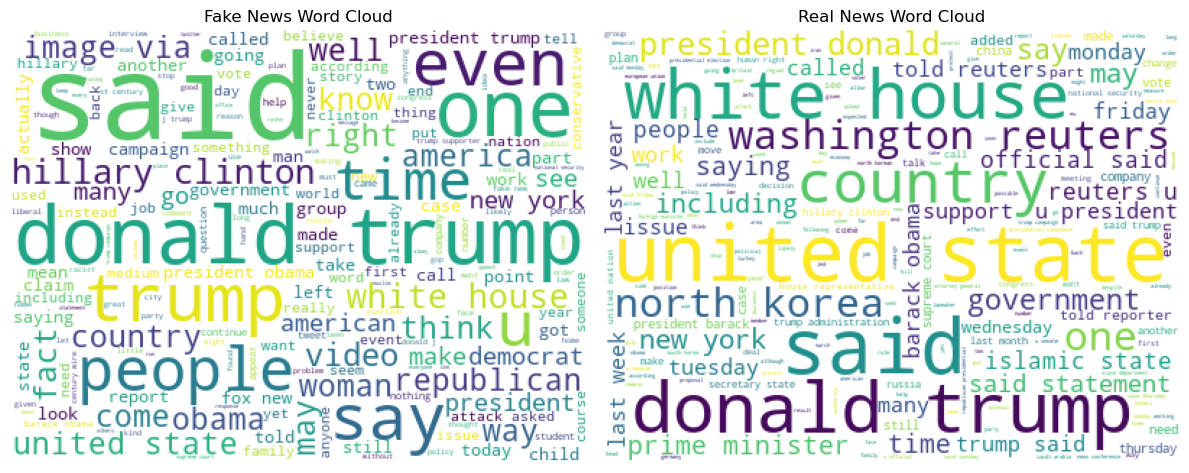

In [31]:
# EDA: Word Clouds

from wordcloud import WordCloud

fake_words = ' '.join(df[df['label'] == 0]['cleaned'])
real_words = ' '.join(df[df['label'] == 1]['cleaned'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(fake_words))
plt.title("Fake News Word Cloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(real_words))
plt.title("Real News Word Cloud")
plt.axis('off')
plt.tight_layout()
plt.show()